In [263]:
import pandas as pd, numpy as np
np.set_printoptions(suppress=True)# 关掉科学计数法
import glob
import os
import csv
# 一次性merge多个pct_chg
from functools import reduce
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels import regression

# import tushare as ts
import time, urllib
# ts.set_token('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')
# pro = ts.pro_api('8ef5ec61cdd848715c57c11d58dd71da1271f76b2420d2bac8aef123')

# import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)


# from plotly.graph_objs import Scatter,Layout
# import plotly
# import plotly.offline as py
# import numpy as np
# import plotly.graph_objs as go

# #setting offilne
# plotly.offline.init_notebook_mode(connected=True)

# TechnicalIndicators

In [264]:
class TechnicalIndicators(object):

    def EMA(df, n, price_col): # n = 5
        """
        Exponential Moving Average
        rationale CHECKED, code CHECKED, updated.

        params:
            df: pd dataframe
            n: number of days = 5
        """
        EMA = df[price_col].ewm(span=n, min_periods=n - 1).mean().rename('EMA_' + str(n))
        return EMA

    def OBV(df, n, price_col, vol_col): # n = 5
        """On-balance Volume

        On Balance Volume (OBV) measures buying and selling pressure as a cumulative indicator that adds 
        volume on up days and subtracts volume on down days. OBV was developed by Joe Granville and introduced 
        in his 1963 book, Granville's New Key to Stock Market Profits. It was one of the first indicators to 
        measure positive and negative volume flow. Chartists can look for divergences between OBV and price 
        to predict price movements or use OBV to confirm price trends.

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:on_balance_volume_obv
        """
        df = df.reset_index()
        i = 0
        OBV = [0]
        while i < df.index[-1]:
            if df.at[i + 1, price_col] - df.at[i, price_col] > 0:
                OBV.append(df.at[i + 1, vol_col])
            if df.at[i + 1, price_col] - df.at[i, price_col] == 0:
                OBV.append(0)
            if df.at[i + 1, price_col] - df.at[i, price_col] < 0:
                OBV.append(-df.at[i + 1, vol_col])
            i = i + 1
        OBV = pd.Series(OBV)
        OBV_ma = pd.Series(OBV.rolling(window=n).mean(), name = 'OBV_' + str(n))
        return OBV_ma

    # Rationale checked
    def MFI(df, n, hi_col, lo_col, price_col, vol_col): # n = 14
        """Money Flow Index and Ratio, updated.
        http://stockcharts.com/docs/doku.php?id=scans:indicators#money_flow_index_mfi

        """
        df = df.reset_index()
        PP = (df[hi_col] + df[lo_col] + df[price_col]) / 3
        i  = 0
        PosMF = [0]
        while i < df.index[-1]:
            if PP[i + 1] > PP[i]:
                PosMF.append(PP[i + 1] * df.at[i + 1, vol_col])
            else:
                PosMF.append(0)
            i = i + 1
        PosMF = pd.Series(PosMF)
        TotMF = PP * df[vol_col]
        MFR   = pd.Series(PosMF / TotMF)
        MFI   = pd.Series(MFR.rolling(window = n, center = False).mean(), name = 'MFI_' + str(n))
        df    = df.join(MFI).set_index("index")
        return df["MFI_" + str(n)]

    # Done
    # Rationale checked
    def RSI(df, n, hi_col, lo_col): # n = 14
        """
        Relative Strength Index, updated.
        Conventional parameters: n = 14, 0.3 and 0.7 are two conventional thresholds
        """
        df = df.reset_index()
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.at[i + 1, hi_col] - df.at[i, hi_col]
            DoMove = df.at[i, lo_col] - df.at[i + 1, lo_col]
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else: UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else: DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI   = pd.Series(UpI)
        DoI   = pd.Series(DoI)
        PosDI = UpI.ewm(span = n, min_periods = n - 1).mean()
        NegDI = DoI.ewm(span = n, min_periods = n - 1).mean()
        RSI   = pd.Series(PosDI / (PosDI + NegDI), name = 'RSI_' + str(n))
        df    = df.join(RSI).set_index("index")
        return df["RSI_" + str(n)]

    def BIAS(df, n, price_col):
        BIAS = df[price_col]-df[price_col].rolling(window=n).mean().rename('BIAS_'+str(n))
        return BIAS

    def MACD(df, n_fast, n_slow, n_macd, price_col): # n_fast = 12, n_slow = 26
        """
        http://stockcharts.com/docs/doku.php?id=scans:indicators
        MACD, MACD Signal and MACD difference, rationale CHECKED, code CHECKED, updated
        # Conventional look-back window for calculating MACDsign is 9
        """
        EMAfast = df[price_col].ewm(span = n_fast, min_periods = n_fast - 1).mean()
        EMAslow = df[price_col].ewm(span = n_slow, min_periods = n_slow - 1).mean()
        MACD = pd.Series(EMAfast - EMAslow, name = 'MACD_' + str(n_fast) + '_' + str(n_slow))
        MACDsign = MACD.ewm(span = n_macd, min_periods = n_macd-1).mean().rename('MACDsign_' + str(n_fast) + '_' + str(n_slow))
        MACDdiff = pd.Series(MACD - MACDsign, name = 'MACDdiff_' + str(n_fast) + '_' + str(n_slow))
        df['MACD_Diff'] = MACD
        df['MACD_Diff_EMA'] = MACDsign
        df['MACD'] = MACDdiff
        df['SIGNAL_STATUS'] = df['MACD'].apply(lambda x: "多头状态" if x>0 else ("空头状态" if x<0 else "无信号状态"))
        return df

# TimeSeriesToolbox

In [265]:
class GetData(object):
    
    def get_date_price_code_df(path, ticker_list, date_col, price_col, code_col):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
#         print(ticker_list)
        for ticker in ticker_list:
            print(ticker)
            try:
#                 print("get thru")
                
                ticker_df = pd.read_csv(path+ticker+".csv")
                ticker_df[code_col] = ticker_df[code_col].astype(str)
                ticker_df = ticker_df.sort_values(date_col)
                ticker_df = ticker_df[[date_col, price_col, code_col]]
#                 print(ticker_df)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
#         print(tickers_data_concated)
        return tickers_data_concated

In [266]:
class TimeSeriesToolbox(object):
        
    def make_numeric_signals(series):
        for item in series:
            if item =="多":
                return 1
            elif item =="空":
                return -1
            else:
                return 0 
            
    def merge_weights_and_signal(df_actions,
                                 df_wts,
                                 path,
                                 code_col,
                                 date_col,
                                 price_col,
                                 tgt_wts_mutiplier,
                                 account_value):
        if df_actions.empty:
            print("There's no data in df_actions. No actional signals for today!")
            pass
            
        else:
            # 合并仓位数据和信号数据
            df_actions_with_weights = df_wts.merge(df_actions, on =code_col)

            # 仓位太小，创建2倍仓位信息, e.g. tgt_wts_mutiplier = 2
            df_actions_with_weights['weight_enlarged'] = df_actions_with_weights['weight']*tgt_wts_mutiplier
    #         print(df_actions_with_weights)
            # 提取下一日要操作的tickers
            tickers = list(df_actions_with_weights[code_col])
    #         print(tickers)
            # 得到这些tickers的收盘价数据
    #         print(tickers)
            tickers_closes = GetData.get_date_price_code_df(path,
                                                             tickers,
                                                             date_col, 
                                                             price_col, 
                                                             code_col)
    #         print(tickers_closes)
            # 创建今日date信息
            last_date = tickers_closes[date_col].values[-1]
    #         print(last_date)
            # 提取最近一天的tickers的收盘价数据
            tickers_closes_last_date = tickers_closes[tickers_closes[date_col] == last_date]

            # 创建最终的信号-仓位指示信息
            df_actions_with_weights = df_actions_with_weights.merge(tickers_closes_last_date, on = [date_col,
                                                                                                    code_col])
            df_actions_with_weights['tgt_shares'] = account_value*\
                                                    df_actions_with_weights['weight_enlarged']/\
                                                    df_actions_with_weights[price_col]
            return df_actions_with_weights
     
    def merge_current_pos_with_target_pos(path, cur_positions, tgt_last_macd_signals):
        tgt_last_macd_signals['TYPE'] = "TARGET"
        # the following variables should be assigned first
        cur_pos_macd = MACDSignals(path, 
                        cur_positions, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
        cur_pos_macd_signals, \
        cur_pos_last_macd_signals, \
        cur_pos_df_actions = cur_pos_macd.calc_macd_signals()
        cur_pos_last_macd_signals['TYPE'] = 'CUR_POS'
        tgt_cur_macd_signal_df = cur_pos_last_macd_signals.merge(tgt_last_macd_signals, on = [date_col,code_col], how = 'outer')
        return tgt_cur_macd_signal_df

# PlotToolBox

In [267]:
class PlotToolbox(object):
    
    def pie_graph(values, labels, pie_length, pie_width, title_name):
        # draw pie graph
        plt.figure(1, figsize = (pie_length, pie_width))
        plt.axes(aspect=1)
        plt.pie(x=values, labels=labels, autopct='%3.1f %%')
        plt.title(title_name, fontsize = 15)
        plt.show()
        
        
    def plot_macd_signals(ticker, macd_signals, tail_num):
        ticker_macd_signals = macd_signals[macd_signals[code_col]==ticker]
        ticker_macd_signals.set_index(date_col, inplace = True)
        ticker_macd_signals[[code_col,"MACD"]].tail(tail_num).plot(figsize = (15,6))

In [268]:
# 在分析环境里，筛选出tickers，然后使用MACD_signals

class MACDSignals(object):
    
    def __init__(self, stocks_path, tickers, date_col, code_col, price_col, n_fast, n_slow, n_macd, ticker_type):
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.n_fast = n_fast
        self.n_slow = n_slow
        self.n_macd = n_macd
        self.ticker_type = ticker_type
        self.mkt_data = self.get_mkt_data_df()

    def get_mkt_data_df(self):
    # e.g. ch_db_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
        csv_path = self.path+"*.csv"
        files = glob.glob(csv_path)
        ticker_df_list = []
        for ticker in tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df[self.code_col] = ticker_df[self.code_col].astype(str)
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        try:
            tickers_data_concated = pd.concat(ticker_df_list)
            tickers_data_concated.reset_index(inplace=True)
            del tickers_data_concated['index']  
        except Exception as e:
            print(e)
        return tickers_data_concated
    

    def calc_macd_signals(self):
        tickers_data_concated = self.mkt_data
#         print(tickers_data_concated)
        signal_record = []
        signal_data = []
        if len(self.tickers)!=1:
            for ticker in self.tickers:
                try:
                    if self.ticker_type == "float":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==float(ticker)]
                    elif self.ticker_type == "string":
                        single_ticker_df = tickers_data_concated[tickers_data_concated[self.code_col]==ticker]
                        
                    signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
                    
                    signal_data.append(signal_df)
                except:
                    pass
            signal_data_df = pd.concat(signal_data)
        else:
            try:                
                signal_df = TechnicalIndicators.MACD(single_ticker_df, self.n_fast, self.n_slow, self.n_macd, self.price_col)
            except:
                pass
            signal_data_df = signal_df

        # v1 is the version of generating the og macd signals
        
        signal_data_df['SIGNAL_DIRECTION'] = signal_data_df['SIGNAL_STATUS'].apply(lambda x: TimeSeriesToolbox.make_numeric_signals(x))
        signal_data_df = signal_data_df.reset_index()
        signal_data_df['SIGNAL_DIRECTION_DIFF'] = signal_data_df.groupby([self.code_col])['SIGNAL_DIRECTION'].diff()
        print("signal_data_df", signal_data_df.head(3))
        signal_data_df['SIGNAL_ACTION'] = signal_data_df['SIGNAL_DIRECTION_DIFF'].apply(lambda x: "LONG" if x==2 else("SHORT" if x==-2 else "NO CHANGE"))
#         print(signal_data_df)
        most_recent_signals = signal_data_df.groupby([self.code_col])[[self.date_col,self.code_col,'SIGNAL_STATUS','SIGNAL_ACTION']].tail(1)
        df_actions = most_recent_signals[most_recent_signals["SIGNAL_ACTION"]!="NO CHANGE"]
        return signal_data_df, most_recent_signals, df_actions

# Risk Parity

In [269]:
from scipy.optimize import minimize

class RiskParity(object):
    
    def __init__(self, stocks_path, tickers, 
                 date_col, code_col, price_col, 
                 ticker_type, asset_name, draw_pie_graph):
        
        self.path = stocks_path
        self.tickers = tickers
        self.date_col = date_col
        self.code_col = code_col
        self.price_col = price_col
        self.ticker_type = ticker_type
        self.asset_name = asset_name
        self.draw_pie_graph = draw_pie_graph
        self.ticker_df_list = self.get_date_price_code_return_list()
        self.tgt_returns = self.ticker_df_list
        self.tgt_merged_returns = self.merge_dfs_by_ticker(self.tgt_returns, 
                                                           self.date_col)
        self.wts, self.risk = self.get_smart_weight(self.tgt_merged_returns, 
                                                    method='risk parity', 
                                                    cov_adjusted=False, 
                                                    wts_adjusted=False)
        self.df_wts, self.risk_parity_tickers, self.weights = self.get_df_wts()
        
        
    # Get date_col, price_col, code_col, pct_chg_col
    def get_date_price_code_return_list(self):
        # for etf data cols are 'date', 'close', 'code'
        ticker_df_list = []
        for ticker in self.tickers:
            try:
                ticker_df = pd.read_csv(self.path+ticker+".csv")
                ticker_df = ticker_df.sort_values(self.date_col)
                ticker_df = ticker_df[[self.date_col, 
                                       self.price_col, 
                                       self.code_col]]
                ticker_df['pct_chg'] = ticker_df[self.price_col].pct_change()
                ticker_df = ticker_df[[self.date_col, 'pct_chg']].dropna()
                ticker_df.columns = [self.date_col, ticker]
                ticker_df_list.append(ticker_df)
            except Exception as e:
                print(e)
        return ticker_df_list
    
    
    def merge_dfs_by_ticker(self, ticker_df_list, date_col):
        merged_all = reduce(lambda left, right: pd.merge(left, right, on=date_col), ticker_df_list)
#         merged_all = reduce(merge_df_for_reduce, ticker_df_list)
        merged_all.set_index(self.date_col, inplace=True)
        merged_all.dropna(how="all", axis = 1, inplace = True)
        merged_all.fillna(method="ffill", inplace = True)
        return merged_all
        
        
    def get_smart_weight(self, pct, method, cov_adjusted, wts_adjusted):
        if cov_adjusted == False:
            #协方差矩阵
            cov_mat = pct.cov()
        else:
            #调整后的半衰协方差矩阵
            cov_mat = pct.iloc[:len(pct)/4].cov()*(1/10.) + pct.iloc[len(pct)/4+1:len(pct)/2].cov()*(2/10.) +\
                pct.iloc[len(pct)/2+1:len(pct)/4*3].cov()*(3/10.) + pct.iloc[len(pct)/4*3+1:].cov()*(4/10.)
        if not isinstance(cov_mat, pd.DataFrame):
            raise ValueError('cov_mat should be pandas DataFrame！')

        omega = np.matrix(cov_mat.values)  # 协方差矩阵
        
        a, b = np.linalg.eig(np.array(cov_mat)) #a为特征值,b为特征向量
        a = np.matrix(a)
        b = np.matrix(b)
        # 定义目标函数
    
        def fun1(x):
            tmp = (omega * np.matrix(x).T).A1
            risk = x * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)

        def fun2(x):
            tmp = (b**(-1) * omega * np.matrix(x).T).A1
            risk = (b**(-1)*np.matrix(x).T).A1 * tmp/ np.sqrt(np.matrix(x) * omega * np.matrix(x).T).A1[0]
            delta_risk = [sum((i - risk)**2) for i in risk]
            return sum(delta_risk)
    
        # 初始值 + 约束条件 
        x0 = np.ones(omega.shape[0]) / omega.shape[0]  
        bnds = tuple((0,None) for x in x0)
        cons = ({'type':'eq', 'fun': lambda x: sum(x) - 1})
        options={'disp':False, 'maxiter':1000, 'ftol':1e-20}
        
        
        #------------------问题出在这里------------------
        if method == 'risk parity':
            res = minimize(fun1, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)        
        elif method == 'pc risk parity':
            res = minimize(fun2, x0, bounds=bnds, constraints=cons, method='SLSQP', options=options)
        #------------------------------------
        
        else:
            raise ValueError('method error！！！')
            
        # 权重调整
        if res['success'] == False:
            # print res['message']
            pass
        wts = pd.Series(index=cov_mat.index, data=res['x'])

        if wts_adjusted == True:
            wts[wts < 0.0001]=0.0
            wts = wts / wts.sum()
        elif wts_adjusted == False:
            wts = wts / wts.sum()
        else:
            raise ValueError('wts_adjusted should be True/False！')

        risk = pd.Series(wts * (omega * np.matrix(wts).T).A1 / np.sqrt(np.matrix(wts) * omega * np.matrix(wts).T).A1[0],index = cov_mat.index)
        risk[risk<0.0] = 0.0
        return wts,risk
    
        
    def get_df_wts(self):
        df_wts = pd.DataFrame(self.wts)
        df_wts.reset_index(inplace = True)
        df_wts.columns = [self.asset_name, 'weight']
        risk_parity_tickers = list(df_wts[self.asset_name])
        weights = list(df_wts['weight'])
        return df_wts, risk_parity_tickers, weights


In [270]:
# Mannually check our current position holdings for potential exit signals:
cur_positions = [
#     "510180",#180ETF
#     "510300",#300ETF
#     "510810",#上海国企
#     "510850",#工银上50
#     "510880",#红利ETF
#     '512000', #券商ETF -
#     '512010',#医药ETF
#     "512400",#有色ETF
#     "512660",#军工ETF
#     '512290',#生物医药ETF -   
    "512380", #MSCI中国指数
    '512690',#酒ETF
#     '512800',#银行ETF
#     '512880',#证券ETF -
     '512980', #传媒ETF
    '159928',#消费ETF

#     '513050',#中概互联网
#     '513100',#纳指ETF
#     '518880',#黄金ETF
#     "159905",#深红利
    "159910", #深100ETF
#     "159920",#恒生ETF
    "159928", #消费ETF
#     "159959", #央企ETF -
#     "159939"# 信息技术
    '159938',#医药 -
    '159952', #创业ETF
#     ''#券商ETF
#     '512960',#央调ETF
#     ''#证券ETF
    '513500'#标普500
#     "513100"#纳指
    
]
len(cur_positions)

9

# Calculating MACD Signals

In [271]:
if __name__=="__main__":
    stocks_path = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
    etfs_df = pd.read_csv("filtered_50_etfs_by_vol_20200224.csv")
    tickers = list(etfs_df['etf'].str.split(".",expand = True)[0])
#     date_col = 'trade_date'
#     code_col = 'ts_code'
#     price_col = 'close'
    date_col = 'date'
    code_col = 'code'
    price_col = 'close'
    ticker_type = 'string'
    asset_name = "code"
    tgt_wts_mutiplier = 4
    account_value = 100000
    
#     # ========For calculating MACD signals========
    n_fast = 12
    n_slow = 26
    n_macd = 9
    macd = MACDSignals(stocks_path, 
                        tickers, 
                        date_col, 
                        code_col, 
                        price_col, 
                        n_fast, 
                        n_slow, 
                        n_macd, 
                        ticker_type)
    macd_signals, last_macd_signals, df_actions = macd.calc_macd_signals()

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

signal_data_df    index        date   open  close   high    low     volume    code  \
0      0  2013-07-29  2.633  2.626  2.640  2.614  1404335.0  518880   
1      1  2013-07-30  2.632  2.646  2.648  2.632   929931.0  518880   
2      2  2013-07-31  2.643  2.657  2.659  2.640   699761.0  518880   

   MACD_Diff  MACD_Diff_EMA  MACD SIGNAL_STATUS  SIGNAL_DIRECTION  \
0        NaN            NaN   NaN         无信号状态                 0   
1        NaN            NaN   NaN         无信号状态                 0   
2        NaN            NaN   NaN         无信号状态                 0   

   SIGNAL_DIRECTION_DIFF  
0                    NaN  
1                    0.0  
2                    0.0  


# Delete tickers that are not up-to-date to make sure RP can function well

In [272]:
if macd_signals['date'].values[-1]==last_macd_signals['date'].values[-1]:
    last_date = last_macd_signals['date'].values[-1] 
else:
    print("日期有问题！")
tickers = list(last_macd_signals[last_macd_signals['date']==last_date]['code'])
print("The number of Tickers Left is: ", len(tickers))

The number of Tickers Left is:  49


In [273]:
last_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION
1735,2020-09-08,518880,空头状态,NO CHANGE
3357,2020-09-08,513500,空头状态,NO CHANGE
5143,2020-09-08,513100,空头状态,SHORT
7063,2020-09-08,159920,空头状态,NO CHANGE
8885,2020-09-08,510500,空头状态,NO CHANGE
9772,2020-09-08,513050,空头状态,NO CHANGE
12368,2020-09-08,510180,空头状态,NO CHANGE
14287,2020-09-08,510900,空头状态,NO CHANGE
16883,2020-09-08,159901,空头状态,NO CHANGE
17205,2020-09-08,512290,空头状态,NO CHANGE


# Calculate Risk-Parity Positions

In [274]:
# ========For calculating risk-parity weights========
risk_parity = RiskParity(stocks_path,
                          tickers,
                          date_col,
                          code_col,
                          price_col,
                          ticker_type,
                          asset_name,
                          True)

df_wts, risk_parity_tickers, weights = risk_parity.get_df_wts()

# Check if there's any new position to be entered

In [275]:
df_actions_with_weights = TimeSeriesToolbox.merge_weights_and_signal(df_actions,
                                                                 df_wts,
                                                                 stocks_path,
                                                                 code_col,
                                                                 date_col,
                                                                 price_col,
                                                                 tgt_wts_mutiplier,
                                                                 account_value)
#     PlotToolbox.pie_graph(weights, risk_parity_tickers, 8, 8, "Risk Parity Allocation")

513100
512690


In [276]:
last_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION
1735,2020-09-08,518880,空头状态,NO CHANGE
3357,2020-09-08,513500,空头状态,NO CHANGE
5143,2020-09-08,513100,空头状态,SHORT
7063,2020-09-08,159920,空头状态,NO CHANGE
8885,2020-09-08,510500,空头状态,NO CHANGE
9772,2020-09-08,513050,空头状态,NO CHANGE
12368,2020-09-08,510180,空头状态,NO CHANGE
14287,2020-09-08,510900,空头状态,NO CHANGE
16883,2020-09-08,159901,空头状态,NO CHANGE
17205,2020-09-08,512290,空头状态,NO CHANGE


In [277]:
last_macd_signals[last_macd_signals['SIGNAL_STATUS']=='多头状态']

,date,code,SIGNAL_STATUS,SIGNAL_ACTION
32879,2020/8/7,159915,多头状态,NO CHANGE


In [278]:
last_macd_signals = last_macd_signals[last_macd_signals['date']==last_date]

In [279]:
macd_signals

,index,date,open,close,high,low,volume,code,MACD_Diff,MACD_Diff_EMA,MACD,SIGNAL_STATUS,SIGNAL_DIRECTION,SIGNAL_DIRECTION_DIFF,SIGNAL_ACTION
0,0,2013-07-29,2.633,2.626,2.640,2.614,1404335.0,518880,NaN,NaN,NaN,无信号状态,0,NaN,NO CHANGE
1,1,2013-07-30,2.632,2.646,2.648,2.632,929931.0,518880,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
2,2,2013-07-31,2.643,2.657,2.659,2.640,699761.0,518880,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
3,3,2013-08-01,2.653,2.643,2.656,2.635,300064.0,518880,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
4,4,2013-08-02,2.630,2.578,2.632,2.558,330218.0,518880,NaN,NaN,NaN,无信号状态,0,0.0,NO CHANGE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66115,66115,2020-09-02,1.348,1.350,1.355,1.338,138689.0,512380,0.023484,0.021955,0.001528,多头状态,1,0.0,NO CHANGE
66116,66116,2020-09-03,1.349,1.341,1.359,1.339,168141.0,512380,0.023029,0.022170,0.000859,多头状态,1,0.0,NO CHANGE
66117,66117,2020-09-04,1.294,1.329,1.336,1.294,112478.0,512380,0.021453,0.022026,-0.000574,空头状态,-1,-2.0,SHORT
66118,66118,2020-09-07,1.328,1.302,1.334,1.297,268762.0,512380,0.017819,0.021185,-0.003366,空头状态,-1,0.0,NO CHANGE


# Merge current position and target positions

In [280]:
last_macd_signals

,date,code,SIGNAL_STATUS,SIGNAL_ACTION
1735,2020-09-08,518880,空头状态,NO CHANGE
3357,2020-09-08,513500,空头状态,NO CHANGE
5143,2020-09-08,513100,空头状态,SHORT
7063,2020-09-08,159920,空头状态,NO CHANGE
8885,2020-09-08,510500,空头状态,NO CHANGE
9772,2020-09-08,513050,空头状态,NO CHANGE
12368,2020-09-08,510180,空头状态,NO CHANGE
14287,2020-09-08,510900,空头状态,NO CHANGE
16883,2020-09-08,159901,空头状态,NO CHANGE
17205,2020-09-08,512290,空头状态,NO CHANGE


In [281]:
tgt_cur_pos_df = TimeSeriesToolbox.merge_current_pos_with_target_pos(stocks_path, cur_positions, last_macd_signals)

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


signal_data_df    index        date   open  close   high    low    volume    code  MACD_Diff  \
0  63671  2019-04-30  0.960  0.973  0.980  0.960  176255.0  512380        NaN   
1  63672  2019-05-06  0.944  0.912  0.944  0.902  254559.0  512380        NaN   
2  63673  2019-05-07  0.911  0.923  0.929  0.907  108649.0  512380        NaN   

   MACD_Diff_EMA  MACD SIGNAL_STATUS  SIGNAL_DIRECTION  SIGNAL_DIRECTION_DIFF  
0            NaN   NaN         无信号状态                 0                    NaN  
1            NaN   NaN         无信号状态                 0                    0.0  
2            NaN   NaN         无信号状态                 0                    0.0  


/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [282]:
def find_recent_goldcross_close(close, signal_diff):
    if signal_diff == 1 or signal_diff == 2:
        return close

    
    
macd_signals['recent_goldcross'] = macd_signals.apply(lambda row: find_recent_goldcross_close(row['close'],row['SIGNAL_DIRECTION_DIFF']), axis=1)
# forward-fill all NaNs for the recent_goldcross to pave way for calculating the pct_diff between current 
# close and the rencent goldcross close
macd_signals['recent_goldcross_ffill'] = macd_signals.groupby("code")['recent_goldcross'].apply(lambda x: x.fillna(method="ffill"))
macd_signals['pctchg_from_recent_goldcrossclose'] = (macd_signals['close']-macd_signals['recent_goldcross_ffill'])/macd_signals['recent_goldcross_ffill']
macd_signals['reentry_rank'] = macd_signals.groupby(["date"])['pctchg_from_recent_goldcrossclose'].rank(ascending = True)
last_day = macd_signals['date'].values[-1]
macd_signals_reentry = macd_signals[macd_signals['date']==last_day][macd_signals['pctchg_from_recent_goldcrossclose']<0]

/Users/miaoyuesun/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [283]:
all_reentry_tickers = list(macd_signals_reentry['code'])
tickers_to_reenter = []
for ticker in all_reentry_tickers:
    if ticker not in cur_positions:
        tickers_to_reenter.append(ticker)

In [284]:
tickers_to_reenter_df = pd.DataFrame(tickers_to_reenter, columns=['code'])
df_actions_with_weights_reentry = df_wts.merge(tickers_to_reenter_df, on = ['code'])
macd_signals_reentry = macd_signals[macd_signals['date']==last_day]
df_actions_with_weights_reentry = df_actions_with_weights_reentry.merge(macd_signals_reentry, on = 'code')
df_actions_with_weights_reentry['weight_enlarged'] = df_actions_with_weights_reentry['weight']*tgt_wts_mutiplier

In [285]:
df_actions_with_weights_reentry['tgt_shares'] = account_value*\
                                                    df_actions_with_weights_reentry['weight_enlarged']/\
                                                    df_actions_with_weights_reentry[price_col]

df_actions_with_weights_reentry = df_actions_with_weights_reentry[['code','date','SIGNAL_STATUS','SIGNAL_ACTION',\
                                                                   'weight_enlarged','close','tgt_shares',\
                                                                   'pctchg_from_recent_goldcrossclose','reentry_rank']]
df_actions_with_weights_reentry.sort_values('reentry_rank', ascending=True, inplace=True)
df_actions_with_weights_reentry_L = df_actions_with_weights_reentry[df_actions_with_weights_reentry['SIGNAL_STATUS']=="多头状态"]

In [286]:
df_actions_with_weights_reentry_L

,code,date,SIGNAL_STATUS,SIGNAL_ACTION,weight_enlarged,close,tgt_shares,pctchg_from_recent_goldcrossclose,reentry_rank


In [287]:
selected_reentry_tickers = list(df_actions_with_weights_reentry_L['code'])
print("Tickers that need to be re-entered: ", selected_reentry_tickers)

Tickers that need to be re-entered:  []


# Check current positions & new positions

In [288]:
# Show if there are any actions needed to be made for our current positions
tgt_cur_pos_df[tgt_cur_pos_df['TYPE_x']=="CUR_POS"]

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
0,2020-09-08,512380,空头状态,NO CHANGE,CUR_POS,空头状态,NO CHANGE,TARGET
1,2020-09-08,512690,空头状态,SHORT,CUR_POS,空头状态,SHORT,TARGET
2,2020-09-08,512980,空头状态,NO CHANGE,CUR_POS,空头状态,NO CHANGE,TARGET
3,2020-09-08,159928,空头状态,NO CHANGE,CUR_POS,空头状态,NO CHANGE,TARGET
4,2020-09-08,159938,空头状态,NO CHANGE,CUR_POS,空头状态,NO CHANGE,TARGET
5,2020-09-08,159952,空头状态,NO CHANGE,CUR_POS,空头状态,NO CHANGE,TARGET
6,2020-09-08,513500,空头状态,NO CHANGE,CUR_POS,空头状态,NO CHANGE,TARGET


In [289]:
# Check if there are any new positions to be entered
tgt_cur_pos_df[(tgt_cur_pos_df['TYPE_x']!="CUR_POS")&(tgt_cur_pos_df['SIGNAL_ACTION_y']!="NO CHANGE")]

,date,code,SIGNAL_STATUS_x,SIGNAL_ACTION_x,TYPE_x,SIGNAL_STATUS_y,SIGNAL_ACTION_y,TYPE_y
8,2020-09-08,513100,NaN,NaN,NaN,空头状态,SHORT,TARGET


In [290]:
try:
    df_actions_with_weights = df_actions_with_weights[df_actions_with_weights['SIGNAL_ACTION']=='LONG']
except:
    df_actions_with_weights = []

try:
    df_actions_tickers = list(df_actions_with_weights['code'])
except:
    df_actions_tickers = []

symbol_list_to_backtest = df_actions_tickers+selected_reentry_tickers
print("All tickers that to be entered before backtesting are:", symbol_list_to_backtest)

All tickers that to be entered before backtesting are: []


# Backtest and Filter:

In [291]:
from CH_backtest import *

In [292]:
ticker_performances = {}

if __name__ == "__main__":
    for ticker in symbol_list_to_backtest:
    # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
        equity_folder = "./"
        csv_dir = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/CH_database/"
#         data_cols = ['trade_date', 'open', 'high','low', 'close', 'volume','ts_code'] #for ETFs # 要改代码
#         data_cols = ['ts_code','trade_date','open','high','low','close','pre_close','change','pct_chg','vol','amount'] #for stocks
#         commissions = 5 # RMB/USD per trade #要改代码
        initial_capital = 1000000.0
        start_date = datetime.datetime(1991,12,1,0,0,0)
        start_date_str = str(start_date)
        heartbeat = 0.0
#         price_col = "close" #要改代码
#         qty = 5000 # 要改代码
        backtest = Backtest(csv_dir, 
                            [ticker], 
                            initial_capital, 
                            heartbeat,
                            start_date,
                            HistoricCSVDataHandler, 
                            SimulatedExecutionHandler, 
                            Portfolio, 
    #                         MovingAverageCrossStrategy,
                           MovingAverageConvergenceDivergence)

        backtest.simulate_trading()
        df_equity = pd.read_csv(ticker+"_performance"+".csv")
        df_equity.drop_duplicates("datetime", inplace = True)
        df_equity =df_equity[df_equity['datetime']>start_date_str]
        df_equity.index = df_equity['datetime']
        df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
        df_equity.columns = ['datetime', 'market_value', 'cash', 'commission', 'total', 'returns',
        'equity_curve', 'drawdown']
        df_equity_copy = df_equity.copy()
        data = df_equity_copy
#         win_rate, mean_win_loss_ratio, bt_score, profits = performance(data)
        single_stats = performance(data)
#         print("TICKER: ", ticker)
        ticker_performances[ticker] = single_stats

# Final Results

In [293]:
pd.DataFrame(ticker_performances)

""


In [294]:
df_actions_with_weights

,code,weight,date,SIGNAL_STATUS,SIGNAL_ACTION,weight_enlarged,close,tgt_shares


In [295]:
df_actions_with_weights_reentry_L

,code,date,SIGNAL_STATUS,SIGNAL_ACTION,weight_enlarged,close,tgt_shares,pctchg_from_recent_goldcrossclose,reentry_rank


# Visualize Signal Status on Long/Shorts

In [296]:
def MACD_long_short_counts(macd_signals, date_col, code_col):
    long_short_counts = macd_signals.groupby([date_col,'SIGNAL_DIRECTION'])[code_col].count()
    long_short_counts_df = pd.DataFrame(long_short_counts)
    long_short_counts_df.reset_index(inplace=True)
    long_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==1]
    short_counts_df = long_short_counts_df[long_short_counts_df['SIGNAL_DIRECTION']==-1]
    long_short_counts_df_merged = long_counts_df.merge(short_counts_df, on = date_col)
    long_short_counts_df_merged['long_short_ratio'] = long_short_counts_df_merged['code_x']/(\
                                                                            long_short_counts_df_merged['code_x']+\
                                                                            long_short_counts_df_merged['code_y'])
    long_short_counts_df_merged.index = pd.to_datetime(long_short_counts_df_merged[date_col])
    return long_short_counts_df_merged

In [297]:
macd_long_short_counts = MACD_long_short_counts(macd_signals, date_col, code_col)

In [298]:
macd_long_short_counts

,date,SIGNAL_DIRECTION_x,code_x,SIGNAL_DIRECTION_y,code_y,long_short_ratio
date,,,,,,
2010-03-12,2010-03-12,1,3,-1,2,0.600000
2010-03-15,2010-03-15,1,2,-1,3,0.400000
2010-03-17,2010-03-17,1,2,-1,3,0.400000
2010-03-18,2010-03-18,1,3,-1,2,0.600000
2010-03-19,2010-03-19,1,3,-1,2,0.600000
...,...,...,...,...,...,...
2020-09-01,2020-09-01,1,24,-1,25,0.489796
2020-09-02,2020-09-02,1,27,-1,22,0.551020
2020-09-03,2020-09-03,1,24,-1,25,0.489796


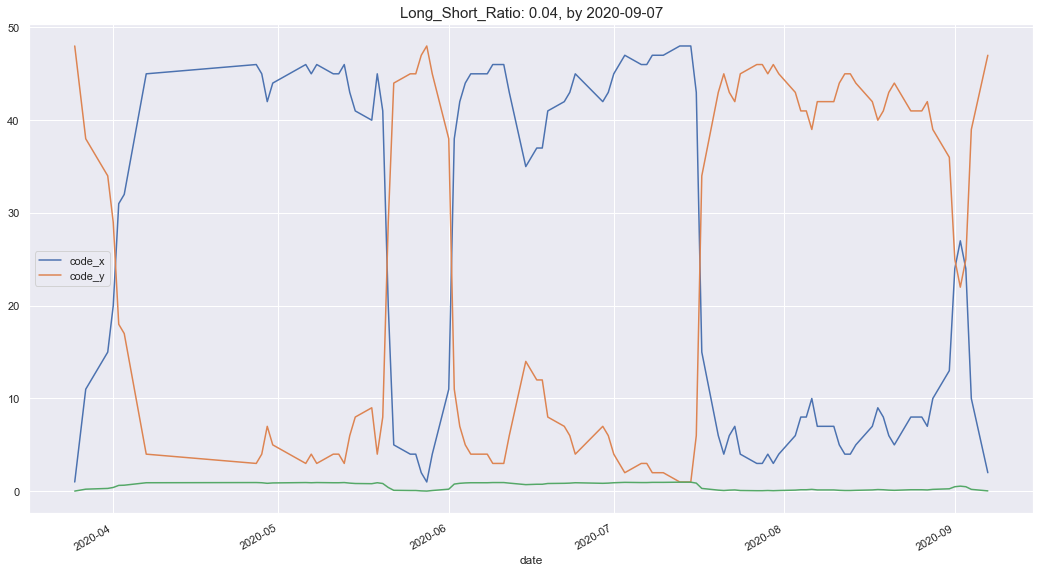

In [299]:
today = macd_long_short_counts[date_col].values[-1]
macd_long_short_counts[['code_x','code_y']].tail(100).plot(figsize = (18,10));
plt.title("Daily Number of Long Signals vs Short Signals for 50 ETFs by {}".format(today), fontsize = 17);

macd_long_short_counts['long_short_ratio'].tail(100).plot(figsize = (18,10))
long_short_ratio = macd_long_short_counts['long_short_ratio'].values[-1]
plt.title("Long_Short_Ratio: {}, by {}".format(round(long_short_ratio,2), today), fontsize =15);